In [64]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [65]:
base_dir = "../logs/SPEC-CPU/"
# Define trace names and configuration labels
trace_names = ['429.mcf-184B', '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B', '602.gcc_s-2226B']
configs = ['baseline', 'ipcp-l1', 'ipcp-l1-l2', 'isb-l1', 'isb-l2']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values = {trace: {} for trace in trace_names}


In [66]:
ipc_values

{'429.mcf-184B': {},
 '450.soplex-247B': {},
 '462.libquantum-714B': {},
 '471.omnetpp-188B': {},
 '482.sphinx3-234B': {},
 '602.gcc_s-2226B': {}}

In [67]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        ipc_values[trace][config] = extract_ipc(log_file)


In [68]:
# Calculate speedups relative to the baseline
speedups = {trace: {} for trace in trace_names}

for trace in trace_names:
    baseline_ipc = ipc_values[trace]['baseline']
    for config in configs[1:]:  # Skip baseline
        speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
# Calculate geometric mean for each configuration (excluding baseline)
geomeans = {}
for config in configs[1:]:
    config_speedups = [speedups[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

speedups['Geomean'] = geomeans
trace_names += ['Geomean']

In [69]:
speedups

{'429.mcf-184B': {'ipcp-l1': 1.189947486871718,
  'ipcp-l1-l2': 1.1905432668846823,
  'isb-l1': 1.127457592553478,
  'isb-l2': 1.1059060881725284},
 '450.soplex-247B': {'ipcp-l1': 1.3543471720818292,
  'ipcp-l1-l2': 1.3832468411552348,
  'isb-l1': 1.4011168772563178,
  'isb-l2': 1.4130678399518652},
 '462.libquantum-714B': {'ipcp-l1': 1.4574295591519566,
  'ipcp-l1-l2': 1.55763249405982,
  'isb-l1': 1.4323380344887369,
  'isb-l2': 1.4245418667971979},
 '471.omnetpp-188B': {'ipcp-l1': 1.0313069383303854,
  'ipcp-l1-l2': 1.0422257983003285,
  'isb-l1': 1.3757985219862305,
  'isb-l2': 1.3000802400996574},
 '482.sphinx3-234B': {'ipcp-l1': 1.482130433935978,
  'ipcp-l1-l2': 1.4445272517742107,
  'isb-l1': 1.4347113377789658,
  'isb-l2': 1.4092466086858002},
 '602.gcc_s-2226B': {'ipcp-l1': 3.882139626616738,
  'ipcp-l1-l2': 4.008582491757606,
  'isb-l1': 3.208481329307231,
  'isb-l2': 2.654300780847664},
 'Geomean': {'ipcp-l1': np.float64(1.5513096063227347),
  'ipcp-l1-l2': np.float64(1.578

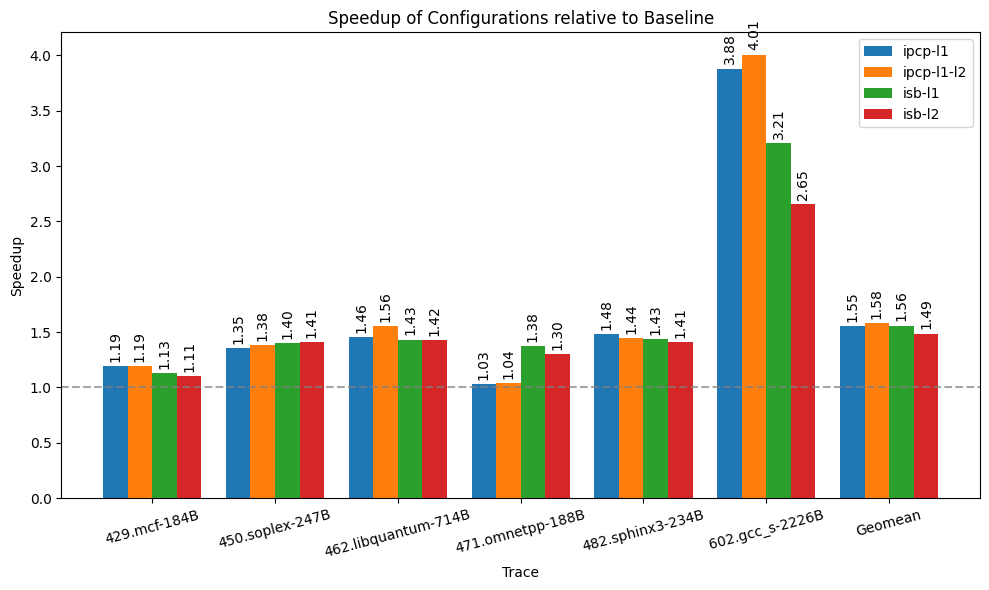

In [71]:
# Plotting the speedups
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each configuration
for i, config in enumerate(configs[1:]):  # Skip baseline
    speedup_values = [speedups[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, speedup_values, width, label=config)
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add a translucent dashed line at y=1.0 for the baseline
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


# Add labels and titles
ax.set_xlabel('Trace')
ax.set_ylabel('Speedup')
ax.set_title('Speedup of Configurations relative to Baseline')
ax.set_xticks(x + 3*width / 2)
ax.set_xticklabels(trace_names, rotation=15)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
